In [37]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import matplotlib as plt
import seaborn as sns
sns.set_style('darkgrid')

In [38]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executer.memory", "4g")
    .getOrCreate()
)

In [50]:
sdf = spark.read.parquet("../data/curated/full_data/")
merchant_df = pd.read_csv("../data/tables/merchant_fraud_probability.csv")
consumer_df = pd.read_csv("../data/tables/consumer_fraud_probability.csv")

<AxesSubplot:xlabel='fraud_probability', ylabel='Count'>

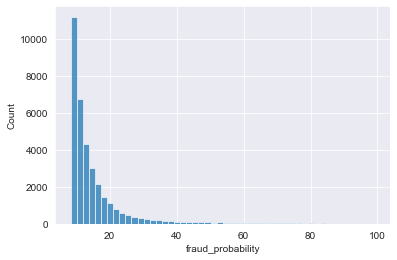

In [40]:
sns.histplot(consumer_df["fraud_probability"], bins=50)

<AxesSubplot:xlabel='fraud_probability', ylabel='Count'>

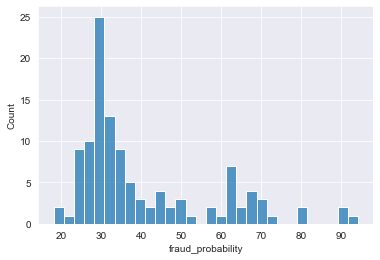

In [41]:
sns.histplot(merchant_df["fraud_probability"], bins=30)

In [34]:
# sorted(consumer_df["order_datetime"].unique())
# data from 2021-02-28 to 2022-02-27

In [42]:
consumer_df.head()

,user_id,order_datetime,fraud_probability
0,6228,2021-12-19,97.629808
1,21419,2021-12-10,99.247380
2,5606,2021-10-17,84.058250
3,3101,2021-04-17,91.421921
4,22239,2021-10-19,94.703425


In [64]:
consumer_fraud_sdf = spark.read.csv("../data/tables/consumer_fraud_probability.csv", inferSchema =True, header=True)
consumer_fraud_sdf = consumer_fraud_sdf.withColumn("order_datetime",consumer_fraud_sdf.order_datetime.cast('date'))
consumer_fraud_sdf.count()

34864

In [65]:
consumer_fraud_sdf.distinct().count() # repeated rows exist in dataset

34765

In [66]:
# delete duplicate records
consumer_fraud_sdf = consumer_fraud_sdf.dropDuplicates()
consumer_fraud_sdf.count()

34765

In [67]:
sample = sdf.join(consumer_fraud_sdf, ["order_datetime", "user_id"], how="inner")
sample.count()

71637

In [68]:
sample.sort(sample.fraud_probability.desc())

order_datetime,user_id,SA2_code,postcode,consumer_id,state,gender,mean_total_income,merchant_abn,dollar_value,order_id,name,tags,revenue_level,take_rate,fraud_probability
2021-12-19,6228,208011169,3186,1242133,VIC,Male,137864,49549583265,1682.693398737649,aea2185e-5c06-42e...,Luctus Et Incorpo...,tent,a,5.69,97.6298077657765
2021-12-19,6228,208011169,3186,1242133,VIC,Male,137864,21025433654,2.7444223963251986,f127f49d-f703-4a4...,Lorem Foundation,digital goods,a,6.55,97.6298077657765
2021-10-19,22239,212011288,3813,184299,VIC,Male,58390,67264251405,51876.637563877644,09206be9-492c-414...,Elit Dictum Eu Fo...,art dealer,a,6.4,94.70342477508035
2021-10-06,8347,207011151,3123,1691,VIC,Male,104364,73972053940,13.807156691382522,c2d13756-1ebe-44f...,Quis Tristique Ac...,tent,b,3.88,92.99138306039121
2022-02-25,17900,103021064,2805,476053,NSW,Female,46863,11149063370,42797.34835914282,b0bdd444-223a-4b4...,Et Arcu Limited,art dealer,b,4.84,92.73262811161372
2021-04-17,3101,509021242,6484,27622,WA,Male,80842,91880575299,105193.88578925544,2ab65c8f-11b2-41c...,At Foundation,antique,b,3.4,91.42192091901347
2022-02-20,16556,312011338,4743,1243659,QLD,Male,82565,49322182190,170.51251362734206,b609fa57-bfb8-4f2...,Gravida Mauris In...,watch,a,6.35,89.65663294494827
2022-02-20,16556,312011338,4743,1243659,QLD,Male,82565,92065881715,192.82296700148154,dbe30431-0c1b-469...,Quam Elementum Corp.,opticians,b,4.2,89.65663294494827
2022-02-20,16556,312011338,4743,1243659,QLD,Male,82565,35575706403,50209.505438673325,d444e831-764d-4ca...,Tempus Mauris Ltd,antique,b,3.46,89.65663294494827
2022-01-02,2310,204021066,3677,526977,VIC,Undisclosed,54321,79100970961,41689.73039921748,a40ffe64-0e3a-489...,Nunc Quisque Orna...,antique,b,4.8,87.96418126148595


In [69]:
merchant_fraud_sdf = spark.read.csv("../data/tables/merchant_fraud_probability.csv", inferSchema =True, header=True)
merchant_fraud_sdf = merchant_fraud_sdf.withColumn("order_datetime",merchant_fraud_sdf.order_datetime.cast('date'))
merchant_fraud_sdf.count()

114

In [71]:
merchant_fraud_sdf.distinct().count() # no repeated records

114

In [78]:
merchant_sample = sdf.join(merchant_fraud_sdf, ["merchant_abn", "order_datetime"], how="inner")
merchant_sample.sort(merchant_sample.fraud_probability.desc())

merchant_abn,order_datetime,user_id,SA2_code,postcode,consumer_id,state,gender,mean_total_income,dollar_value,order_id,name,tags,revenue_level,take_rate,fraud_probability
35575706403,2022-02-20,16556,312011338,4743,1243659,QLD,Male,82565,50209.505438673325,d444e831-764d-4ca...,Tempus Mauris Ltd,antique,b,3.46,91.09606847149965
97884414539,2021-10-19,18658,203021037,3216,288499,VIC,Male,56271,44615.02252113347,b89f04f6-13fb-4ec...,Ut Corporation,antique,a,6.82,89.79919971536573
14530561097,2021-09-15,6383,309081261,4230,25238,QLD,Undisclosed,56011,46001.13901942742,00f150fa-dc82-43d...,Duis At Inc.,jewelry,c,1.69,80.80054474543395
18737319630,2021-09-25,14289,117031337,1138,372362,NSW,Male,70738,31.87802890860355,760b62e7-456a-47c...,Ut Industries,computer,a,5.7,72.73069736562613
18737319630,2021-09-25,4095,310011271,4076,73469,QLD,Male,52311,2043.5096770196096,a69922eb-11f4-45d...,Ut Industries,computer,a,5.7,72.73069736562613
18737319630,2021-09-25,21903,116031318,2766,191946,NSW,Female,168493,185.21294554901942,e53d6628-ead8-461...,Ut Industries,computer,a,5.7,72.73069736562613
85482742429,2021-11-27,13027,106011108,2325,1493014,NSW,Female,56848,91.15263125315963,37cbc3ce-149c-4b5...,Mi Eleifend Egest...,gift,b,3.91,70.88131110541714
85482742429,2021-11-27,20253,509021241,6512,597170,WA,Female,82363,24.141374159653708,caff42dc-f5b0-4cf...,Mi Eleifend Egest...,gift,b,3.91,70.88131110541714
85482742429,2021-11-27,13353,216011408,3565,1327404,VIC,Male,47199,118.07626713731234,c1387980-f617-479...,Mi Eleifend Egest...,gift,b,3.91,70.88131110541714
85482742429,2021-11-27,23895,315031410,4733,1395891,QLD,Male,55439,72.88038090808719,1af7fa01-a55a-497...,Mi Eleifend Egest...,gift,b,3.91,70.88131110541714
